#Trabajo final Data Science III
#Pierre Cabot
#Parte 2

Para esta instancia se siguió trabajando con el mismo dataset "Netflix reviews" pero con un enfoque de análisis mediante deep learning.

# 1) Dependencias

In [33]:
%%time
import gzip
import json
import string

from collections import Counter
import requests
import zipfile
import io

import pandas as pd
import numpy  as np
import seaborn as sns
import re
import string
import plotly
import matplotlib.pyplot as plt

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, Bidirectional
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import tensorflow as tf

CPU times: user 59 µs, sys: 4 µs, total: 63 µs
Wall time: 67.2 µs


# 2) Análisis

In [34]:
# URL del archivo ZIP en GitHub
url ='https://github.com/PierreCabot/PierreCODER/raw/main/netflix_reviews.csv.zip'

# Descargo el archivo ZIP
response = requests.get(url)
if response.status_code == 200:
    zip_file = zipfile.ZipFile(io.BytesIO(response.content))

    print("Archivos en el ZIP:", zip_file.namelist())

    csv_file_name = zip_file.namelist()[0]
    with zip_file.open(csv_file_name) as csvfile:
        df = pd.read_csv(csvfile)

    print(df.head())
else:
    print("Error al descargar el archivo:", response.status_code)

Archivos en el ZIP: ['netflix_reviews.csv']
                               reviewId       userName  \
0  94c3dd9a-0ecb-4276-b62d-3d9de692ccac      Kmr Rahul   
1  a2de4715-77be-4d6a-89d2-66364c7a3576              K   
2  2dc3dabe-ec6e-4a58-a23a-57fe0e2cb386     Lisa Salva   
3  8f4c427f-bc4f-45e2-b248-648467742875          Keith   
4  e081d547-a023-42cb-a341-480a69ffde7e  sumitra thapa   

                                             content  score  thumbsUpCount  \
0                                              Supar      5              0   
1                                I hate the new ads.      1              0   
2  I'm noticing that I'm getting all the apps tha...      1              0   
3  Was password sharing really the problem? Y'all...      1              0   
4       It is didn't sign up never use it Netflix 🤦😾      1              0   

     reviewCreatedVersion                   at              appVersion  
0   8.135.1 build 7 50902  2024-10-09 14:45:35   8.135.1 build 7 

In [35]:
df.head(5)

,reviewId,userName,content,score,thumbsUpCount,reviewCreatedVersion,at,appVersion
0,94c3dd9a-0ecb-4276-b62d-3d9de692ccac,Kmr Rahul,Supar,5,0,8.135.1 build 7 50902,2024-10-09 14:45:35,8.135.1 build 7 50902
1,a2de4715-77be-4d6a-89d2-66364c7a3576,K,I hate the new ads.,1,0,8.134.1 build 10 50872,2024-10-09 14:44:59,8.134.1 build 10 50872
2,2dc3dabe-ec6e-4a58-a23a-57fe0e2cb386,Lisa Salva,I'm noticing that I'm getting all the apps tha...,1,0,8.96.1 build 16 50568,2024-10-09 14:36:33,8.96.1 build 16 50568
3,8f4c427f-bc4f-45e2-b248-648467742875,Keith,Was password sharing really the problem? Y'all...,1,0,NaN,2024-10-09 14:34:45,NaN
4,e081d547-a023-42cb-a341-480a69ffde7e,sumitra thapa,It is didn't sign up never use it Netflix 🤦😾,1,0,8.135.1 build 7 50902,2024-10-09 14:31:32,8.135.1 build 7 50902


In [36]:
df['content'] = df['content'].fillna('')

In [37]:
df['Sentiment_rating'] = np.where(df.score > 3, 1, 0) #estandarización de los scores
df['Sentiment_rating'].value_counts()

,count
Sentiment_rating,
0,68579
1,47393


In [38]:
df1=df.iloc[:5000,:] #reducción del tamaño del dataset para achicar los tiempos de análisis

# 3) Tokenización

In [39]:
# Defino parámetros
max_words = 10000
max_len = 100

# Creao y tokenizo el corpus
tokenizer = Tokenizer(num_words=max_words)

tokenizer.fit_on_texts(df1['content'])
sequences = tokenizer.texts_to_sequences(df1['content'])
X = pad_sequences(sequences, maxlen=max_len)

# Creo etiquetas
y = df1['Sentiment_rating']



In [40]:
y.shape

(5000,)

In [41]:
X.shape

(5000, 100)

# 4) LSTM

In [42]:
# Defino el modelo Bidireccional LSTM
bi_lstm_model = Sequential([
    Embedding(input_dim=10000, output_dim=128),
    Bidirectional(LSTM(128)),
    Dense(1, activation='sigmoid')
])

# Compilo el modelo antes de entrenar
bi_lstm_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [43]:
# Entreno el modelo
with tf.device('/GPU:0'):
  model = bi_lstm_model.fit(X, y, epochs=6, batch_size=32, validation_split=0.2)

# Evalúo el modelo
bi_lstm_loss, bi_lstm_accuracy = bi_lstm_model.evaluate(X, y)
print(f'Bidirectional LSTM Test Accuracy: {bi_lstm_accuracy}')

Epoch 1/6
125/125 ━━━━━━━━━━━━━━━━━━━━ 29s 211ms/step - accuracy: 0.6866 - loss: 0.5887 - val_accuracy: 0.8070 - val_loss: 0.4368
Epoch 2/6
125/125 ━━━━━━━━━━━━━━━━━━━━ 41s 209ms/step - accuracy: 0.8652 - loss: 0.3359 - val_accuracy: 0.8230 - val_loss: 0.4227
Epoch 3/6
125/125 ━━━━━━━━━━━━━━━━━━━━ 26s 210ms/step - accuracy: 0.9311 - loss: 0.2096 - val_accuracy: 0.8130 - val_loss: 0.4905
Epoch 4/6
125/125 ━━━━━━━━━━━━━━━━━━━━ 41s 210ms/step - accuracy: 0.9566 - loss: 0.1517 - val_accuracy: 0.8170 - val_loss: 0.5176
Epoch 5/6
125/125 ━━━━━━━━━━━━━━━━━━━━ 41s 208ms/step - accuracy: 0.9667 - loss: 0.1140 - val_accuracy: 0.8150 - val_loss: 0.6110
Epoch 6/6
125/125 ━━━━━━━━━━━━━━━━━━━━ 41s 213ms/step - accuracy: 0.9728 - loss: 0.0925 - val_accuracy: 0.7990 - val_loss: 0.6445
157/157 ━━━━━━━━━━━━━━━━━━━━ 9s 57ms/step - accuracy: 0.9685 - loss: 0.1020
Bidirectional LSTM Test Accuracy: 0.9391999840736389


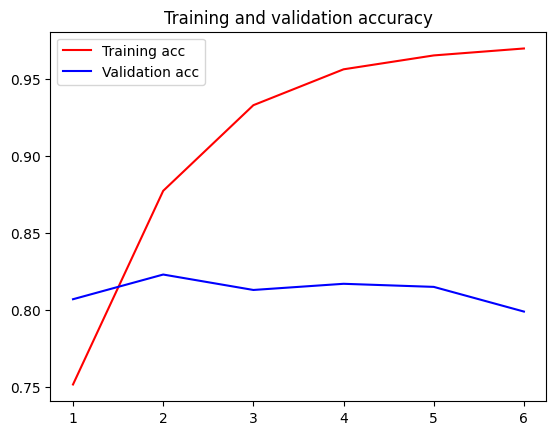

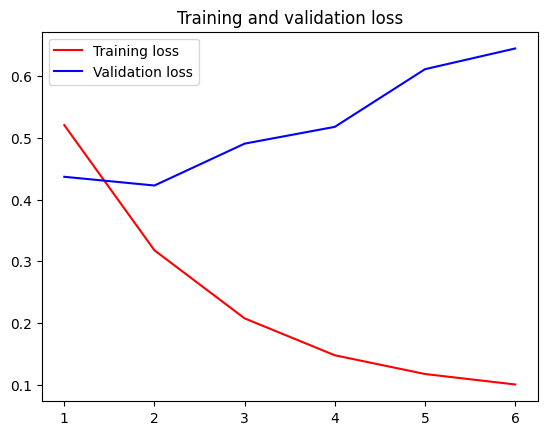

In [44]:
acc = model.history['accuracy']
val_acc = model.history['val_accuracy']
loss = model.history['loss']
val_loss = model.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'r', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()
plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

# Conclusiones

Para esta ocasión, previo procesamiento del dataset con tokenización y estandarización de los scores, se aplicó un modelo de redes neuronales del tipo recurrentes de dos capas bidireccionales. A comparación del modelo de regresión logística que se aplicó en la parte 1 (80% de precisión), este modelo obtuvo una precisión del 94%.
Con más de 6 épocas el modelo no aumentó de precisión. Si bien este modelo tuvo un mejor desempeño que el de ML, su consumo de memoria y tiempo es notablemente mayor (con 5000 registros del dataset al modelo le llevó 3 minutos, por lo que analizar el total del dataset llevaría una hora aproximadamente). Esto debe ser evaluado por la empresa si ello lo amerita.